In this notebook I will give a brief and simple demonstration of Non Max Suppression (NMS) and Intersection over Union (Intersection over Union, or the Jaccard Index). This are algorithms used a lot in object detection algorithms, as together they provide a way to clean up extra boxes that were falsely detected during inference. 

Additionally, IOU, provides a good way to measure the effectiveness of detection algorithms. Mean IOU (mIOU) is a common metric to see in object detection papers. It measures on average how much did the predicted boxes overlap with the ground truth boxes.

Joseph Redmon https://pjreddie.com/, the designer of the Yolo algorithms, uses IOU as one of his measures when training his networks and not only as a metric, although he calls it the objectness. 

In [1]:
%matplotlib inline

import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import cv2

import copy

Below is the function we will use at the end of the code to draw the bounding boxes. The detection model I use spits out boxes with multiple decimal places, which is why I am taking the floor of each coordinate when I draw it.

In [2]:
# draw bounding boxes
def draw_bb(img, boxes):
    for bf in boxes:
        img = cv2.rectangle(img, 
                           (np.floor(bf[0]),  np.floor(bf[1])), 
                           (np.floor(bf[2]),  np.floor(bf[3])), 
                           (255, 0, 0), 1)
    return img

Here, I import the detection model (Faster RCNN https://arxiv.org/pdf/1506.01497.pdf) and set it to eval mode, since we are only using it for inference. The capture magic import (or whatever Jupyter calls them) prevents the copious amount of output resulting from this import from showing.

In [3]:
%%capture

# detection algorithm
det_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
det_model.eval()

Nothing special here. I am using pytorch's transforms to convert the image to a torch tensor so that it can be passed through the network.

In [4]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [5]:
test_img = cv2.imread('./test_image.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

The next line of code is the first thing that has really shown up so far that plays a crucial rol in the NMS algorithm. This threshold value, although it may seems nonintuitive until you wrap your head around the whole algorithm, is used as the separating point in the decisions of which boxes to keep and which not to. Boxes that overlap more than the threshold's amout with the box in question are removed. I will explain this further in a few cells.

In [6]:
nms_thresh = 0.3

Now we have the function thsat performs IOU. It is actually fairly straight forward. It takes in two boxes, so two sets of four coordinates, and checks to see how much they overlap compared pared to how much space they take up in total between the two of them, the intersection over the union (holy toledo batman! that's the name of the algorithm!). This value is then returned and checked against the threshold value that we defined above.

The measurement of the overlap may seem odd. It took me a minute to get a handle on, but if you stare hard enough it works out.

In [7]:
def iou(box_a, box_b):
    # extract box coordinates
    a11, a12, a21, a22 = box_a
    b11, b12, b21, b22 = box_b
    
    # calculate area of boxes - boxes represented as top left and bottom right coordinates
    area_a = (a21-a11)*(a22-a12)
    area_b = (b21-b11)*(b22-b12)
    
    # calculate intersection coordinates
    (i11, i12) = max(a11, b11), max(a12, b12)
    (i21, i22) = min(a21, b21), min(a22, b22)
    
    # area of intersection
    area_i = (i21-i11)*(i22-i12)

    # return intersection over union
    return area_i / (area_a + area_b - area_i)

And here is the NMS algorithm itself, hooray! As you can see, its extremely simple. The most confusing part was probably finding the intersection in the IOU. 

So, the function takes in all of the proposed boxes, which our detection model was kind enough to return to us in decending order of confidence (just to be clear, I mean considence of detection, not confidence of objectness as pjreddie would define. So, how sure are we that this box has classified x, not how sure are we that this box contains x). So, if your model does not return the boxes this way you, will have to sort them.

The algorithm takes the first box (with the highest classification confidence) and adds it into the list of filtered boxes. Then it begins calculating its IOU with respect to all the other boxes in decending order of confidence. For each box it is checked against, if the second box has an IOU higher than nms_threshold with respect to the first box, it is discarded. This is because, it is assumed that if a box overlaps with the box being examined by more than some amount, it is trying to classify the same object. But, because the design of the algorithm says that we are checking everything in decending order of classification condifence, we know that the first box is more confident about what thar object is, and is therefore probably the correct box. (Always wrong but never in doubt...)

This process is continued with the ever dwindling initial proposal list until the last box is reached. At this point, the remaining boxes are returned and used as detections.

-> Note: There may be a lot of boxes. Yolo especially tends to produce a lot of undesirable boxes. Since you are checking against all other boxes, this algorithm takes O(n^2) time to run. Which if you are familiar with big-O notation, means that its run time increases at a rate of the input squared as more input, so as more boxes, are added. For a lot of boxes, this could be a faily high run time. So, it is reasonable in practice to only check against a fixed amount of boxes to reduce this time.

In [8]:
def nms(proposals):
    # filtered boxes
    boxes = []
    
    for box_a in proposals:
        # add box with highest confidence score to list of filtered boxes
        boxes.append(box_a)
        # remove from proposal list all boxes, boxb, if iou with boxa is higher than threshold
        # idea is that high iou boxes are trying to classify same object, but have lower confidence than baxa, most like wrong
        # also remove current boxa from list so boxa will always be box with highest confidence
        proposals = [box_b for box_b in proposals[1:] if iou(box_a, box_b) < nms_thresh]

        if len(proposals) == 0:
            break
        
    # return list of filtered boxes
    return boxes

Here we actually run the model.

In [9]:
output = det_model(transforms(test_img).unsqueeze(0))

boxes = output[0]['boxes'].detach().numpy()    # boxes are returned in descending order of confidence score

Before the final result, the image below shows what the model spit out without performing NMS. It is not too bad, but clearly not optimal as there are a number of overlapping boxes, specifially on the woman in the foreground.

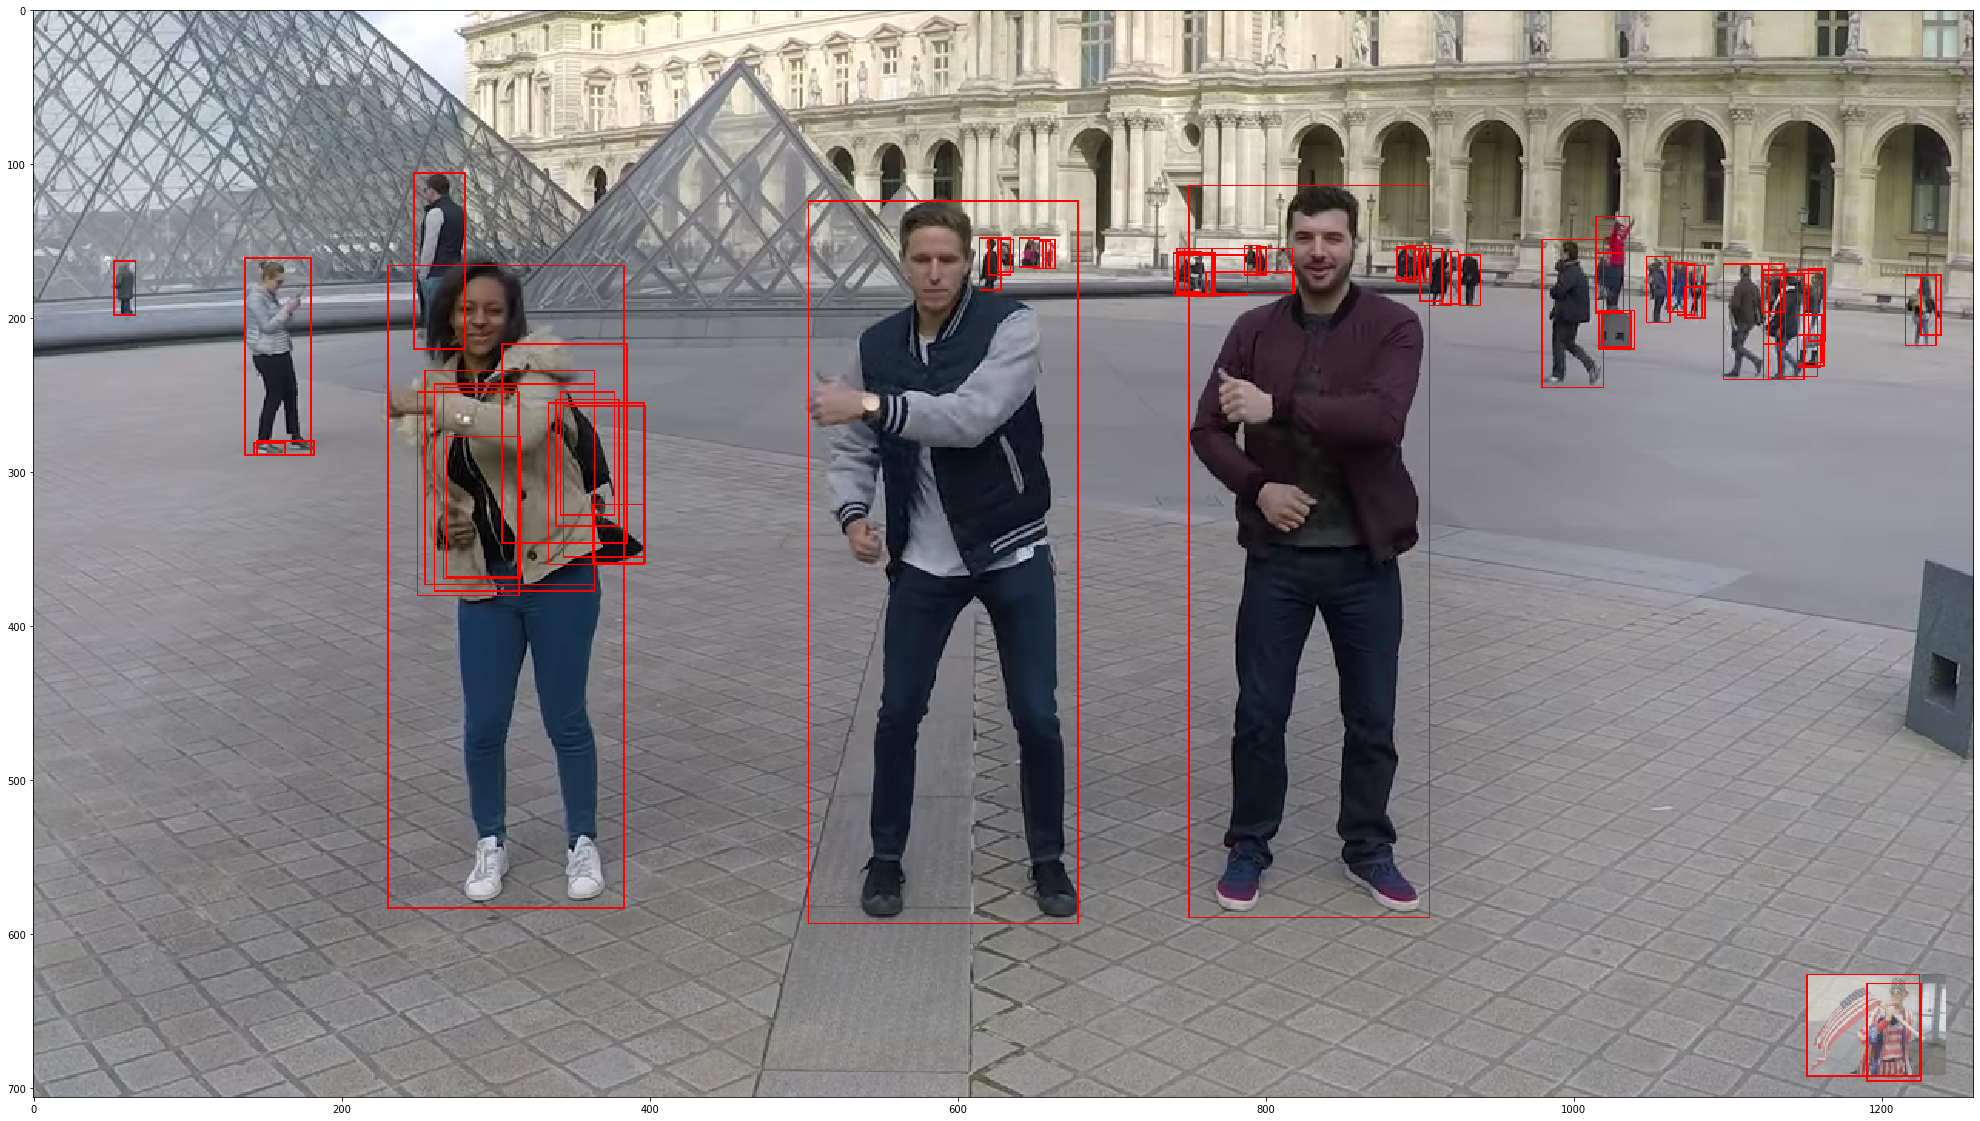

In [10]:
img = copy.deepcopy(test_img)

test_img_no_nms = draw_bb(img, boxes)

fig, ax = plt.subplots(figsize=(36,20))    
ax.imshow(test_img_no_nms)

And finally, we get the final result after performing NMS. As you can see the undesired boxes cleaned up nicely.

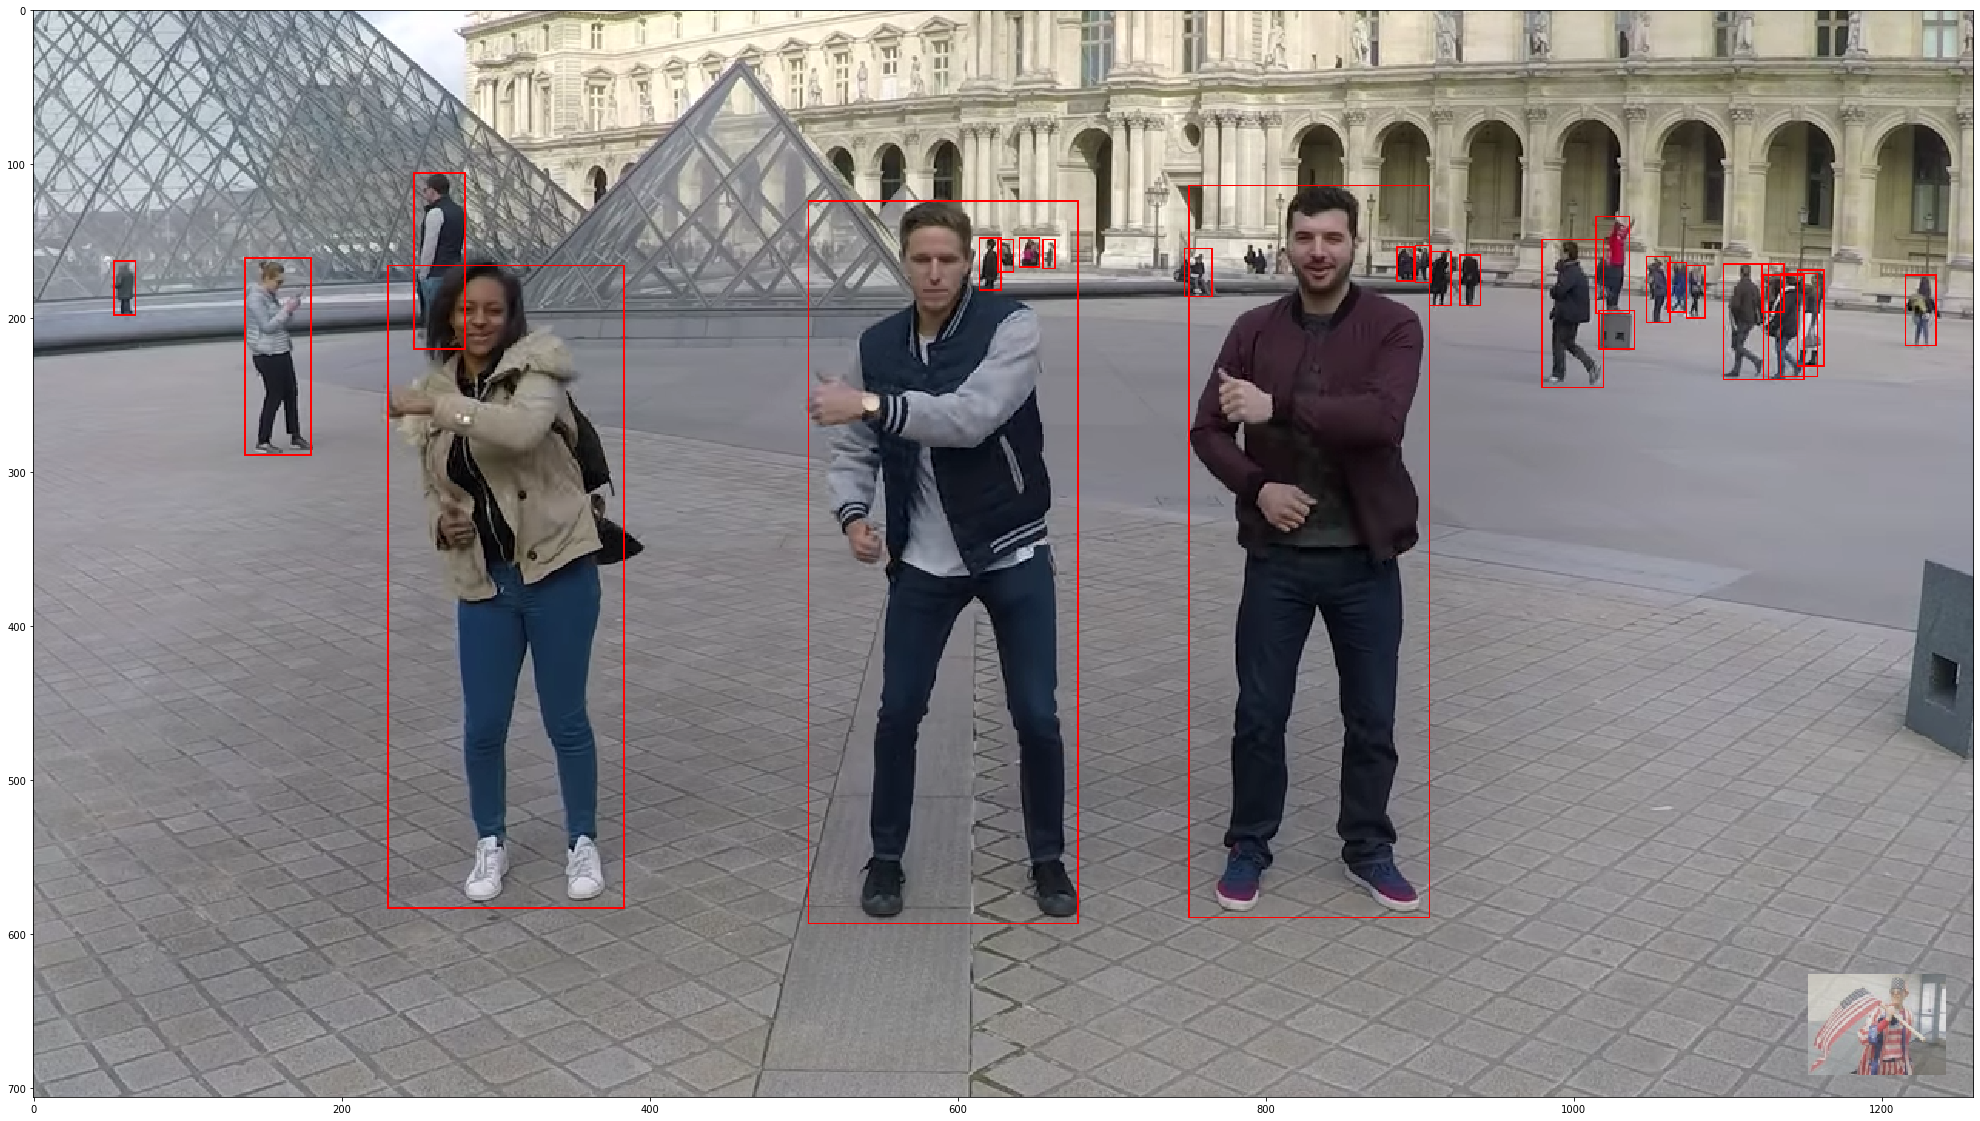

In [12]:
boxes_filt = nms(boxes)

test_img_nms = draw_bb(test_img, boxes_filt)

fig, ax = plt.subplots(figsize=(36,20))    
ax.imshow(test_img_nms)

I'm calling this cell my license because I know that I will not actually add and official one to my github page. Use any of this code that you would like. If you ask my permission, I will ignore you. If you have actuall questions or just want to chat (I don't know, maybe about dogs or something) feel free to shoot me an email or whatever. dylanamiller3@gmail.com.